In [21]:
# Torch Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# HF Transformers
import transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
from transformers import TrainerCallback

#Datahandeling
import numpy as np
import pandas as pd
import datasets
from datasets import Dataset
from datasets import load_metric,list_metrics
import datetime

# GPU Flushing
import gc

# Evaluation
import seaborn as sns
import sklearn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi

Wed Mar  2 13:49:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.13       Driver Version: 496.13       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:25:00.0  On |                  N/A |
| 29%   29C    P8     7W / 120W |   1677MiB /  3072MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce GTX 1060 3GB


In [4]:
train_test_ds = datasets.load_from_disk("../data/processed_data")

In [5]:
MODEL_ARCHITECTURE = 'distilbert-base-uncased' 

In [6]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ARCHITECTURE)

In [7]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_ARCHITECTURE, num_labels=3)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifi

In [8]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [26]:
gc.collect()
torch.cuda.empty_cache()
#1/0

In [41]:
df = pd.read_csv("../data/labeled_data.csv")

In [66]:
class_weights = (1 - (df["class"].value_counts().sort_index()/len(df))).values
class_weights = torch.from_numpy(class_weights).float().to("cuda")
print(class_weights)
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

#torch.tensor([2.0, 1.0, 1.0],device=torch.device("cuda:{}".format(torch.cuda.current_device())))

tensor([0.9423, 0.2257, 0.8320], device='cuda:0')


In [67]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    accuracy = load_metric("accuracy").compute(predictions=predictions, references=labels)
    precision = load_metric("precision").compute(predictions=predictions, references=labels,average="weighted")
    f1 = load_metric("f1").compute(predictions=predictions, references=labels,average="weighted")
    recall = load_metric("recall").compute(predictions=predictions, references=labels,average="weighted")
    return {"accuracy":accuracy, "precision":precision, "recall":recall, "f1":f1}

training_args = TrainingArguments(
    output_dir="../results",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.001,
    evaluation_strategy="epoch",
    resume_from_checkpoint = None,
    logging_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
    logging_steps = 100,
    fp16 = False
    #eval_steps = 500
)

#tb_callback = TrainerCallback()

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_test_ds["train"],
    eval_dataset=train_test_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics = compute_metrics,
#    callbacks = [tb_callback]
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
100%|██████████| 155/155 [42:21<00:00, 16.40s/it]


In [68]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet.
***** Running training *****
  Num examples = 22304
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 4182
  2%|▏         | 100/4182 [01:28<1:06:47,  1.02it/s]

{'loss': 0.0484, 'learning_rate': 9.760879961740794e-06, 'epoch': 0.07}


  5%|▍         | 200/4182 [03:09<25:35,  2.59it/s]  

{'loss': 0.0366, 'learning_rate': 9.521759923481588e-06, 'epoch': 0.14}


  7%|▋         | 300/4182 [04:49<1:02:00,  1.04it/s]

{'loss': 0.0335, 'learning_rate': 9.282639885222381e-06, 'epoch': 0.22}


 10%|▉         | 400/4182 [06:34<1:04:00,  1.02s/it]

{'loss': 0.0468, 'learning_rate': 9.043519846963177e-06, 'epoch': 0.29}


 12%|█▏        | 500/4182 [08:15<1:06:09,  1.08s/it]Saving model checkpoint to ../results\checkpoint-500
Configuration saved in ../results\checkpoint-500\config.json


{'loss': 0.0324, 'learning_rate': 8.80439980870397e-06, 'epoch': 0.36}


Model weights saved in ../results\checkpoint-500\pytorch_model.bin
tokenizer config file saved in ../results\checkpoint-500\tokenizer_config.json
Special tokens file saved in ../results\checkpoint-500\special_tokens_map.json
 14%|█▍        | 600/4182 [10:01<1:02:15,  1.04s/it]

{'loss': 0.0489, 'learning_rate': 8.565279770444764e-06, 'epoch': 0.43}


 17%|█▋        | 700/4182 [11:43<1:05:29,  1.13s/it]

{'loss': 0.0209, 'learning_rate': 8.326159732185559e-06, 'epoch': 0.5}


 19%|█▉        | 800/4182 [13:23<53:24,  1.06it/s]  

{'loss': 0.0151, 'learning_rate': 8.087039693926352e-06, 'epoch': 0.57}


 22%|██▏       | 900/4182 [14:58<53:13,  1.03it/s]  

{'loss': 0.0423, 'learning_rate': 7.847919655667146e-06, 'epoch': 0.65}


 24%|██▍       | 1000/4182 [16:36<50:16,  1.05it/s] Saving model checkpoint to ../results\checkpoint-1000
Configuration saved in ../results\checkpoint-1000\config.json


{'loss': 0.0742, 'learning_rate': 7.608799617407939e-06, 'epoch': 0.72}


Model weights saved in ../results\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in ../results\checkpoint-1000\tokenizer_config.json
Special tokens file saved in ../results\checkpoint-1000\special_tokens_map.json
 26%|██▋       | 1100/4182 [18:13<48:40,  1.06it/s]  

{'loss': 0.0168, 'learning_rate': 7.369679579148733e-06, 'epoch': 0.79}


 29%|██▊       | 1200/4182 [19:48<47:08,  1.05it/s]

{'loss': 0.05, 'learning_rate': 7.130559540889527e-06, 'epoch': 0.86}


 31%|███       | 1300/4182 [21:23<45:36,  1.05it/s]

{'loss': 0.0653, 'learning_rate': 6.8914395026303206e-06, 'epoch': 0.93}


 33%|███▎      | 1394/4182 [22:52<44:02,  1.06it/s]The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet.
***** Running Evaluation *****
  Num examples = 2479
  Batch size = 16
Trainer is attempting to log a value of "{'accuracy': 0.9080274304154902}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9037245797016765}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9080274304154902}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to lo

{'eval_loss': 1.0014368295669556, 'eval_accuracy': {'accuracy': 0.9080274304154902}, 'eval_precision': {'precision': 0.9037245797016765}, 'eval_recall': {'recall': 0.9080274304154902}, 'eval_f1': {'f1': 0.9050928399319774}, 'eval_runtime': 47.2325, 'eval_samples_per_second': 52.485, 'eval_steps_per_second': 3.282, 'epoch': 1.0}


 33%|███▎      | 1400/4182 [23:45<2:34:12,  3.33s/it] 

{'loss': 0.0394, 'learning_rate': 6.652319464371115e-06, 'epoch': 1.0}


 36%|███▌      | 1500/4182 [25:20<42:25,  1.05it/s]  Saving model checkpoint to ../results\checkpoint-1500
Configuration saved in ../results\checkpoint-1500\config.json


{'loss': 0.0007, 'learning_rate': 6.413199426111909e-06, 'epoch': 1.08}


Model weights saved in ../results\checkpoint-1500\pytorch_model.bin
tokenizer config file saved in ../results\checkpoint-1500\tokenizer_config.json
Special tokens file saved in ../results\checkpoint-1500\special_tokens_map.json
 38%|███▊      | 1600/4182 [26:57<40:48,  1.05it/s]  

{'loss': 0.0138, 'learning_rate': 6.174079387852703e-06, 'epoch': 1.15}


 41%|████      | 1700/4182 [28:32<39:17,  1.05it/s]

{'loss': 0.032, 'learning_rate': 5.934959349593496e-06, 'epoch': 1.22}


 43%|████▎     | 1800/4182 [30:07<37:43,  1.05it/s]

{'loss': 0.015, 'learning_rate': 5.695839311334291e-06, 'epoch': 1.29}


 45%|████▌     | 1900/4182 [31:42<36:15,  1.05it/s]

{'loss': 0.0083, 'learning_rate': 5.456719273075084e-06, 'epoch': 1.36}


 48%|████▊     | 2000/4182 [33:17<34:25,  1.06it/s]Saving model checkpoint to ../results\checkpoint-2000
Configuration saved in ../results\checkpoint-2000\config.json


{'loss': 0.0299, 'learning_rate': 5.217599234815878e-06, 'epoch': 1.43}


Model weights saved in ../results\checkpoint-2000\pytorch_model.bin
tokenizer config file saved in ../results\checkpoint-2000\tokenizer_config.json
Special tokens file saved in ../results\checkpoint-2000\special_tokens_map.json
 50%|█████     | 2100/4182 [34:54<32:50,  1.06it/s]

{'loss': 0.0111, 'learning_rate': 4.978479196556672e-06, 'epoch': 1.51}


 53%|█████▎    | 2200/4182 [36:29<31:23,  1.05it/s]

{'loss': 0.0157, 'learning_rate': 4.7393591582974654e-06, 'epoch': 1.58}


 55%|█████▍    | 2300/4182 [38:04<29:42,  1.06it/s]

{'loss': 0.0478, 'learning_rate': 4.50023912003826e-06, 'epoch': 1.65}


 57%|█████▋    | 2400/4182 [39:38<28:11,  1.05it/s]

{'loss': 0.0119, 'learning_rate': 4.261119081779053e-06, 'epoch': 1.72}


 60%|█████▉    | 2500/4182 [41:13<26:35,  1.05it/s]Saving model checkpoint to ../results\checkpoint-2500
Configuration saved in ../results\checkpoint-2500\config.json


{'loss': 0.0597, 'learning_rate': 4.021999043519848e-06, 'epoch': 1.79}


Model weights saved in ../results\checkpoint-2500\pytorch_model.bin
tokenizer config file saved in ../results\checkpoint-2500\tokenizer_config.json
Special tokens file saved in ../results\checkpoint-2500\special_tokens_map.json
 62%|██████▏   | 2600/4182 [42:50<24:59,  1.05it/s]

{'loss': 0.0792, 'learning_rate': 3.782879005260641e-06, 'epoch': 1.87}


 65%|██████▍   | 2700/4182 [44:25<23:25,  1.05it/s]

{'loss': 0.098, 'learning_rate': 3.543758967001435e-06, 'epoch': 1.94}


 67%|██████▋   | 2788/4182 [45:48<22:00,  1.06it/s]The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet.
***** Running Evaluation *****
  Num examples = 2479
  Batch size = 16
Trainer is attempting to log a value of "{'accuracy': 0.8979427188382412}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9049523869649683}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.8979427188382412}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to lo

{'eval_loss': 1.054342269897461, 'eval_accuracy': {'accuracy': 0.8979427188382412}, 'eval_precision': {'precision': 0.9049523869649683}, 'eval_recall': {'recall': 0.8979427188382412}, 'eval_f1': {'f1': 0.9011146780464666}, 'eval_runtime': 47.1901, 'eval_samples_per_second': 52.532, 'eval_steps_per_second': 3.285, 'epoch': 2.0}


 67%|██████▋   | 2800/4182 [46:47<28:18,  1.23s/it]  

{'loss': 0.114, 'learning_rate': 3.3046389287422286e-06, 'epoch': 2.01}


 69%|██████▉   | 2900/4182 [48:22<20:16,  1.05it/s]

{'loss': 0.0473, 'learning_rate': 3.065518890483023e-06, 'epoch': 2.08}


 72%|███████▏  | 3000/4182 [49:57<18:40,  1.05it/s]Saving model checkpoint to ../results\checkpoint-3000
Configuration saved in ../results\checkpoint-3000\config.json


{'loss': 0.0712, 'learning_rate': 2.826398852223817e-06, 'epoch': 2.15}


Model weights saved in ../results\checkpoint-3000\pytorch_model.bin
tokenizer config file saved in ../results\checkpoint-3000\tokenizer_config.json
Special tokens file saved in ../results\checkpoint-3000\special_tokens_map.json
 74%|███████▍  | 3100/4182 [51:33<17:04,  1.06it/s]

{'loss': 0.0455, 'learning_rate': 2.5872788139646103e-06, 'epoch': 2.22}


 77%|███████▋  | 3200/4182 [53:08<15:31,  1.05it/s]

{'loss': 0.0567, 'learning_rate': 2.3481587757054043e-06, 'epoch': 2.3}


 79%|███████▉  | 3300/4182 [54:43<13:59,  1.05it/s]

{'loss': 0.0574, 'learning_rate': 2.109038737446198e-06, 'epoch': 2.37}


 81%|████████▏ | 3400/4182 [56:18<12:20,  1.06it/s]

{'loss': 0.0619, 'learning_rate': 1.8699186991869919e-06, 'epoch': 2.44}


 84%|████████▎ | 3500/4182 [57:53<10:45,  1.06it/s]Saving model checkpoint to ../results\checkpoint-3500
Configuration saved in ../results\checkpoint-3500\config.json


{'loss': 0.0484, 'learning_rate': 1.630798660927786e-06, 'epoch': 2.51}


Model weights saved in ../results\checkpoint-3500\pytorch_model.bin
tokenizer config file saved in ../results\checkpoint-3500\tokenizer_config.json
Special tokens file saved in ../results\checkpoint-3500\special_tokens_map.json
 86%|████████▌ | 3600/4182 [59:30<09:11,  1.05it/s]

{'loss': 0.0466, 'learning_rate': 1.3916786226685797e-06, 'epoch': 2.58}


 88%|████████▊ | 3700/4182 [1:01:04<07:36,  1.06it/s]

{'loss': 0.0475, 'learning_rate': 1.1525585844093734e-06, 'epoch': 2.65}


 91%|█████████ | 3800/4182 [1:02:40<06:44,  1.06s/it]

{'loss': 0.038, 'learning_rate': 9.134385461501674e-07, 'epoch': 2.73}


 93%|█████████▎| 3900/4182 [1:04:14<04:42,  1.00s/it]

{'loss': 0.0728, 'learning_rate': 6.743185078909613e-07, 'epoch': 2.8}


 96%|█████████▌| 4000/4182 [1:05:54<03:01,  1.00it/s]Saving model checkpoint to ../results\checkpoint-4000
Configuration saved in ../results\checkpoint-4000\config.json


{'loss': 0.08, 'learning_rate': 4.3519846963175517e-07, 'epoch': 2.87}


Model weights saved in ../results\checkpoint-4000\pytorch_model.bin
tokenizer config file saved in ../results\checkpoint-4000\tokenizer_config.json
Special tokens file saved in ../results\checkpoint-4000\special_tokens_map.json
 98%|█████████▊| 4100/4182 [1:07:36<01:22,  1.00s/it]

{'loss': 0.0559, 'learning_rate': 1.9607843137254904e-07, 'epoch': 2.94}


100%|██████████| 4182/4182 [1:08:04<00:00,  3.59it/s]The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet.
***** Running Evaluation *****
  Num examples = 2479
  Batch size = 16
Trainer is attempting to log a value of "{'accuracy': 0.9043969342476805}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9043381041566014}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9043969342476805}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to 

{'eval_loss': 1.1118172407150269, 'eval_accuracy': {'accuracy': 0.9043969342476805}, 'eval_precision': {'precision': 0.9043381041566014}, 'eval_recall': {'recall': 0.9043969342476805}, 'eval_f1': {'f1': 0.9043609053663563}, 'eval_runtime': 17.993, 'eval_samples_per_second': 137.776, 'eval_steps_per_second': 8.614, 'epoch': 3.0}
{'train_runtime': 4102.9973, 'train_samples_per_second': 16.308, 'train_steps_per_second': 1.019, 'train_loss': 0.04501018460816826, 'epoch': 3.0}


TrainOutput(global_step=4182, training_loss=0.04501018460816826, metrics={'train_runtime': 4102.9973, 'train_samples_per_second': 16.308, 'train_steps_per_second': 1.019, 'train_loss': 0.04501018460816826, 'epoch': 3.0})

In [69]:
model_path = "../results/last-model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Configuration saved in ../results/last-model\config.json
Model weights saved in ../results/last-model\pytorch_model.bin
tokenizer config file saved in ../results/last-model\tokenizer_config.json
Special tokens file saved in ../results/last-model\special_tokens_map.json


('../results/last-model\\tokenizer_config.json',
 '../results/last-model\\special_tokens_map.json',
 '../results/last-model\\vocab.txt',
 '../results/last-model\\added_tokens.json',
 '../results/last-model\\tokenizer.json')

In [70]:
predictions = trainer.predict(train_test_ds["test"])
print(predictions.predictions.shape, predictions.label_ids.shape)

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet.
***** Running Prediction *****
  Num examples = 2479
  Batch size = 16
100%|██████████| 155/155 [00:24<00:00, 11.27it/s]

(2479, 3) (2479,)


In [75]:
y_preds = np.argmax(predictions.predictions, axis=-1)

In [76]:
# constant for classes
classes = ("hate","offensive","neither")


In [77]:
print(classification_report(y_true=predictions.label_ids,y_pred = y_preds))

              precision    recall  f1-score   support

           0       0.44      0.44      0.44       141
           1       0.94      0.94      0.94      1941
           2       0.87      0.88      0.88       397

    accuracy                           0.90      2479
   macro avg       0.75      0.76      0.75      2479
weighted avg       0.90      0.90      0.90      2479



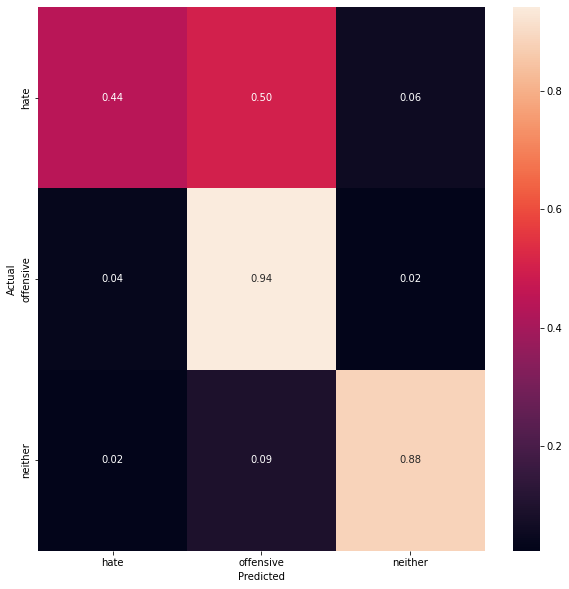

In [78]:

target_names = ("hate","offensive","neither")
cm = confusion_matrix(y_true=predictions.label_ids,y_pred=y_preds)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)